### Profesor: Dr. Pedro O. Perez
### Alumno: Daniel Hurtado
#### Fecha: 19-11-2023

## Simulación de Almacenamiento con Agentes Autónomos

### Descripción General
Este código implementa una simulación de un sistema de almacenamiento automatizado utilizando agentes autónomos, específicamente robots de almacenamiento. El objetivo es optimizar la distribución de cajas en un almacén.

### Estructura del Código
1. **Importaciones**: Se importan bibliotecas necesarias como `mesa` para la simulación basada en agentes, `numpy` y `pandas` para el manejo de datos numéricos, y `matplotlib` para visualización.

2. **Constantes**: Se definen constantes como `SEED` para reproducibilidad, `EMPTY` para celdas vacías y `MAX_BOX_STACK` para el apilamiento máximo de cajas.

3. **Clase `StorageRobot`**: Representa un robot de almacenamiento, capaz de transportar y apilar cajas.
   - **Métodos clave**:
     - `move`: Mueve al agente a una celda vecina vacía.
     - `pick_box` y `stack_box`: Recogen y apilan cajas respectivamente.
     - `get_best_cell`: Identifica la mejor celda para moverse según una condición dada.

4. **Clase `StorageModel`**: Modelo del sistema de almacenamiento.
   - **Inicialización**: Crea una grid, coloca agentes y distribuye cajas.
   - **Métodos clave**:
     - `step`: Avanza un paso en la simulación, recopilando datos y actualizando el estado.
     - `is_finished`: Verifica si la simulación ha alcanzado su condición de finalización (todas las cajas están apiladas adecuadamente).

5. **Visualización**: Se utiliza `matplotlib` para mostrar el estado inicial del almacén y la progresión de la simulación.

6. **Ejecución de la Simulación**: Se inicializa el modelo y se ejecuta hasta que se completa o se alcanza el número máximo de pasos. Se mide el tiempo total de ejecución.

### Estrategia y Mecanismos Utilizados
- **Agentes Autónomos**: Cada robot opera independientemente, tomando decisiones basadas en su entorno inmediato.
- **Búsqueda Local**: Los robots buscan en sus vecindades cercanas para encontrar la mejor acción (recoger o apilar cajas).
- **Distribución Aleatoria de Cajas**: Las cajas se distribuyen aleatoriamente al inicio, representando un entorno desordenado típico de un almacén.

### Posibles Mejoras
- **Optimización de Rutas**: Implementar algoritmos de búsqueda de caminos para minimizar el movimiento innecesario.
- **Colaboración entre Agentes**: Permitir que los robots colaboren o se comuniquen para evitar sobreposiciones y optimizar la distribución del trabajo.

### Reducción de Pasos
Para reducir el número de pasos en la simulación, se podrían implementar las siguientes estrategias:
- **Planificación Centralizada**: Utilizar un sistema de control central para dirigir a los robots de manera más eficiente.
- **Aprendizaje Automático**: Entrenar a los agentes mediante técnicas de aprendizaje por refuerzo para mejorar su eficiencia en la toma de decisiones.

## Imports

In [38]:
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd
import random

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

### Constantes

In [39]:
SEED = 67890
EMPTY = 0
MAX_BOX_STACK = 5

# Agente de la simulación


In [40]:
class StorageRobot(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)
        self.carrying_box = False
        self.random.seed(SEED)
    
    def step(self):
        x, y = self.pos
        if self.carrying_box:
            self.stack_box(x, y)
        else:
            self.pick_box(x, y)

    def move(self, x, y):
        possible_moves = [cell for cell in self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False) if self.model.grid.is_cell_empty(cell)]

        if possible_moves:
            new_position = random.choice(possible_moves)
            self.model.grid.move_agent(self, new_position)

    def get_best_cell(self, condition):
        neighboor_cells = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=True)
        best_value = -1
        best_cell = None

        for cell in neighboor_cells:
            cell_x, cell_y = cell
            cell_value = self.model.get_cell_value(cell_x, cell_y)

            if condition(cell_x, cell_y) and cell_value > best_value:
                best_value = cell_value
                best_cell = cell

        return best_cell

    def pick_box(self, x, y):
        def condition(cell_x, cell_y):
            return not self.model.is_empty(cell_x, cell_y) and not self.model.is_full(cell_x, cell_y)

        best_cell = self.get_best_cell(condition)

        if best_cell:
            self.model.pick_box(*best_cell)
            self.carrying_box = True

        self.move(x, y)

    def stack_box(self, x, y):
        def condition(cell_x, cell_y):
            return not self.model.is_full(cell_x, cell_y) and not self.model.is_empty(cell_x, cell_y)

        best_cell = self.get_best_cell(condition)

        if best_cell:
            self.model.stack_box(*best_cell)
            self.carrying_box = False

        self.move(x, y)



In [41]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )
    grid = np.copy(model.boxes_amount)
    return grid

## Modelo de la simulación

In [42]:
class StorageModel(Model):
    def __init__(self, width, height, num_agents, total_boxes):
        self.grid = SingleGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"CellValues": get_grid})
        self.boxes_amount = np.zeros((width, height))
        self.steps = 0
        self.total_boxes_grid = 0
        self.finished = False
        self.random.seed(SEED)

        self.generate_agents(num_agents)
        self.generate_boxes(total_boxes)

    def generate_agents(self, num_agents):
        id = 0
        for _ in range(num_agents):
            agent = StorageRobot(id, self)
            self.schedule.add(agent)
            x, y = self.random_empty_cell()
            self.grid.place_agent(agent, (x, y))
            id += 1

    def generate_boxes(self, total_boxes):
        while total_boxes > self.total_boxes_grid:
            x, y = self.random_empty_cell()
            if total_boxes - self.total_boxes_grid >= 3:
                option = np.random.randint(1, 4)
            elif total_boxes - self.total_boxes_grid == 2:
                option = np.random.randint(1, 3)
            elif total_boxes - self.total_boxes_grid == 1:
                option = np.random.randint(1, 2)
            self.boxes_amount[x][y] = option
            self.total_boxes_grid += option
        print(f"El número de cajas en el grid son: {self.total_boxes_grid}")

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.steps += 1
        self.is_finished()

    def get_steps(self):
        return self.steps

    def is_state(self, x, y, state):
        return self.boxes_amount[x][y] == state

    def is_empty(self, x, y):
        return self.is_state(x, y, 0)

    def is_full(self, x, y):
        return self.is_state(x, y, 5)

    def stack_box(self, x, y):
        self.boxes_amount[x][y] += 1

    def pick_box(self, x, y):
        self.boxes_amount[x][y] -= 1

    def has_box(self, x, y):
        return self.get_cell_value(x, y) > 0

    def get_cell_value(self, x, y):
        return self.boxes_amount[x][y]
    
    def is_finished(self):
        for x in range(self.grid.width):
            for y in range(self.grid.height):
                cell_value = self.boxes_amount[x][y]
                if cell_value != 0 and cell_value != 5:
                    return False
        self.finished = True
        return True
    
    def get_finished(self):
        return self.finished

    def random_empty_cell(self):
        valid_positions = [(x, y) for x in range(self.grid.width) for y in range(self.grid.height) if self.grid.is_cell_empty((x, y)) and self.boxes_amount[x][y] < 3]
        return random.choice(valid_positions)

    def random_pos(self):
        return random.choice(list(self.grid.G.nodes))

In [43]:
def show_graph(model):
   boxes_counts = np.zeros( (model.grid.width, model.grid.height) )
   for cell in model.grid.coord_iter():
       (cell_content, (x, y)) = cell
       boxes_counts[x][y] = model.get_cell_value(x, y)

   plt.imshow(boxes_counts, interpolation='nearest', cmap=plt.cm.Reds)
   plt.colorbar()

El número de cajas en el grid son: 200


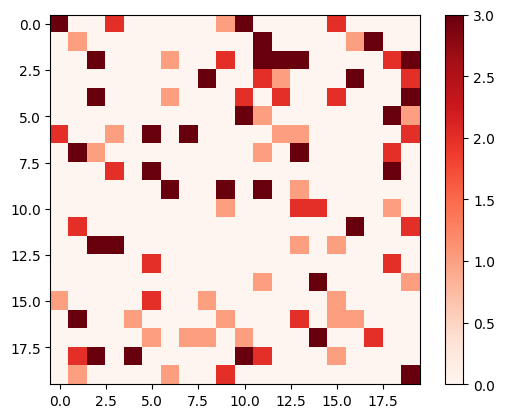

In [44]:
WIDTH = 20
HEIGHT = 20
NUM_AGENTS = 5
TOTAL_BOXES = 200
MAX_STEPS = 100000

model = StorageModel(WIDTH, HEIGHT, NUM_AGENTS, TOTAL_BOXES)
show_graph(model)

Pasos necesarios para terminar la simulacion: 3030


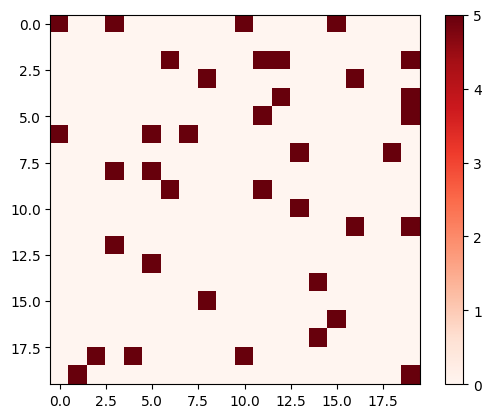

In [45]:
# Start the timer
start_time = round(time.time(), 2)

step = 0
while step < MAX_STEPS and not model.get_finished():
    model.step()
    step += 1

# Stop the timer
end_time = round(time.time() - start_time, 2)
print(f"Pasos necesarios para terminar la simulacion: {model.get_steps()}")
show_graph(model)


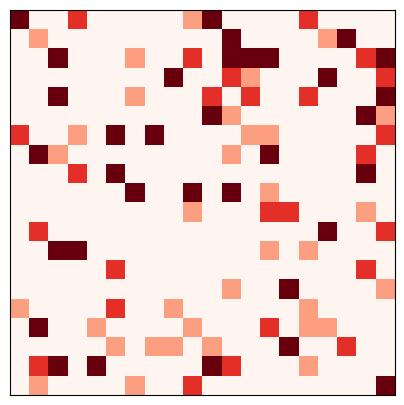

In [46]:
all_grid = model.datacollector.get_model_vars_dataframe()
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.Reds)

def animate(frame):
    patch.set_data(all_grid.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=model.get_steps() - 1)

In [47]:
anim

KeyboardInterrupt: 